during the ETLT
1. combine both motorist and sgcarmart
2. names to be extracted -> brand and model 
3. fetch data from API
4. combine both APIs together to get 1 dataset
5. derive the vehicle classes
6. fetch the COE prices

In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from google.cloud import bigquery
pd.set_option('display.max_columns', None)

In [133]:
# read dataset first
# data = pd.read_csv('../Datasets/final_combined_dataset.csv')

path_to_private_key = 'is3107-418903-a6116d294003.json'
bigquery_client = bigquery.Client.from_service_account_json(json_credentials_path=path_to_private_key)

sql = """
        SELECT * FROM `is3107-418903.final.carsCombinedFinal`
        """
data = bigquery_client.query(sql).to_dataframe()

In [134]:
data = data.dropna()

In [135]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,accessories,model_make_id,make,model_trim,model_year,model_body,model_seats,model_weight_kg,model_engine_fuel,model_engine_cyl,model_drive,model_transmission_type,model_fuel_cap_l,vehicle_class
0,1,2487.0,100800.0,18300.0,78789.0,155.0,4.62,35969.0,32357.0,"Original sports rims, electric driver seat, Al...",84,Toyota,14926,2018,Sedan,5,1469.841270,regular unleaded,I4,front wheel drive,8-speed shiftable automatic,54.8825,B
1,2,1991.0,65800.0,25500.0,146000.0,135.0,0.43,47421.0,58390.0,"Andriod HU, Dual electric memory seats, revers...",303,Mercedes-Benz,22900,2015,Sedan,5,1904.761905,diesel fuel,I4,rear wheel drive,7-speed shiftable automatic,79.8635,B
3,3,1984.0,72800.0,19890.0,108000.0,162.0,2.64,34596.0,40435.0,"VW R-line body kit, Panoramic roof and 19'' BB...",390,Volkswagen,20981,2016,Sedan,5,1479.818594,regular unleaded,I4,front wheel drive,6-speed shiftable automatic,70.0225,B
4,1,1998.0,30800.0,19580.0,78524.0,177.0,0.04,17723.0,17723.0,"Digital info display, drive mode select, sport...",354,Subaru,23453,2015,SUV,5,1643.537415,premium unleaded (required),flat 4,all wheel drive,continuously variable-speed automatic,60.1815,B
5,4,1598.0,33800.0,18170.0,133000.0,125.0,0.02,32618.0,27666.0,"LED Headlights, Electric Seats, Retractable Mi...",9,BMW,21258,2015,Sedan,5,1514.739229,premium unleaded (required),I4,rear wheel drive,8-speed shiftable automatic,59.8030,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,1,1591.0,63800.0,13600.0,110000.0,93.8,4.18,13775.0,13775.0,"Sports rims, leather seats, driver electric se...",440,Hyundai,13580,2018,Hatchback,5,1334.693878,regular unleaded,I4,front wheel drive,6-speed shiftable automatic,52.9900,A
4197,1,1591.0,51800.0,13830.0,68388.0,93.8,3.28,12881.0,12881.0,"Cruise control, rear aircon, LED daytime runni...",440,Hyundai,16589,2017,Hatchback,5,1318.820862,regular unleaded,I4,front wheel drive,6-speed shiftable automatic,49.9620,A
4198,1,1591.0,73800.0,14490.0,73679.0,93.8,4.58,14645.0,14645.0,"Certified cars, one-year warranty, no mileage ...",440,Hyundai,13580,2018,Hatchback,5,1334.693878,regular unleaded,I4,front wheel drive,6-speed shiftable automatic,52.9900,A
4199,2,1591.0,63888.0,13250.0,108000.0,93.8,4.27,14456.0,14456.0,"Memory seats, multi function steering, rear ai...",440,Hyundai,13580,2018,Hatchback,5,1334.693878,regular unleaded,I4,front wheel drive,6-speed shiftable automatic,52.9900,A


# Data Processing

In [136]:
# checking the data types
data.dtypes

owners                       Int64
eng_cap                    float64
price                      float64
depreciation               float64
mileage                    float64
power                      float64
coe_left                   float64
omv                        float64
arf                        float64
accessories                 object
model_make_id                Int64
make                        object
model_trim                   Int64
model_year                   Int64
model_body                  object
model_seats                  Int64
model_weight_kg            float64
model_engine_fuel           object
model_engine_cyl            object
model_drive                 object
model_transmission_type     object
model_fuel_cap_l           float64
vehicle_class               object
dtype: object

In [137]:
# # converting to integers
# data['model_year'] = data['model_year'].astype("Int64")
# data['model_seats'] = data['model_seats'].astype("Int64")

# # 2dp 
# data['model_weight_kg'] = data['model_weight_kg'].round(2)
# data['model_fuel_cap_l'] = data['model_fuel_cap_l'].round(2)

# # converting to datetime
# data['reg_date'] = pd.to_datetime(data['reg_date'])

# drop model trim
columns_to_drop = ['model_trim', 'accessories', 'model_make_id', 'vehicle_class']
data = data.drop(columns=columns_to_drop)

## Encoding Model Body

In [138]:
# before replacing data 
print(data['model_body'].value_counts())

model_body
Sedan          915
SUV            690
Hatchback      508
Coupe          230
Convertible    223
Minivan         16
Name: count, dtype: int64


In [139]:
data.iloc[0]['model_body'].lower()

'sedan'

In [140]:
# encode model_body

for index, row in data.iterrows():
    row['model_body'] = row['model_body'].lower()
    if 'sport' in row['model_body']:
        data.at[index, 'model_body'] ='SUV'
    elif 'compact' in row['model_body'] or 'subcompact' in row['model_body']:
        data.at[index, 'model_body'] ='Compact Cars'
    elif 'manual' in row['model_body']:
        data.at[index, 'model_body'] ='Manual'
    elif 'wagon' in row['model_body']:
        data.at[index, 'model_body'] ='Wagon'
        
# after replacing data 
print(data['model_body'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_body'], drop_first=True)

model_body
Sedan          915
SUV            690
Hatchback      508
Coupe          230
Convertible    223
Minivan         16
Name: count, dtype: int64


## Encoding Model Transmission Type

In [141]:
# before replacing data 
print(data['model_transmission_type'].value_counts())

model_transmission_type
8-speed shiftable automatic              655
7-speed automated manual                 439
continuously variable-speed automatic    411
9-speed shiftable automatic              299
6-speed manual                           285
6-speed shiftable automatic              233
7-speed shiftable automatic              150
6-speed automated manual                  57
5-speed manual                            21
6-speed automatic                         16
8-speed automated manual                  15
4-speed automatic                          1
Name: count, dtype: int64


In [142]:
data['model_transmission_type'].dtype

dtype('O')

In [143]:
# encode transmission_type
for index, row in data.iterrows():
    row['model_transmission_type'] = row['model_transmission_type'].lower()
    if 'continuously' in row['model_transmission_type'] or 'single Speed' in row['model_transmission_type'] or 'cvt' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='CVT'
    elif 'automatic' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Automatic'
    elif 'manual' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Manual'
    elif 'automated manual' in row['model_transmission_type']:
        data.at[index, 'model_transmission_type'] ='Automated Manual'
    else:
        data.at[index, 'model_transmission_type'] ='Others'

# after replacing data
print(data['model_transmission_type'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_transmission_type'], drop_first=True)


model_transmission_type
Automatic    1354
Manual        817
CVT           411
Name: count, dtype: int64


## Encoding Model Drive

In [144]:
# before replacing data 
print(data['model_drive'].value_counts())

model_drive
front wheel drive    1065
all wheel drive       885
rear wheel drive      589
four wheel drive       43
Name: count, dtype: int64


In [145]:
#encode model_drive
for index, row in data.iterrows():
    row['model_drive'] = row['model_drive'].lower()
    if 'all' in row['model_drive'] or '4wd' in row['model_drive'] or 'awd' in row['model_drive'] or 'four' in row['model_drive']:
        data.at[index, 'model_drive'] ='All Wheel Drive'
    elif 'front' in row['model_drive']:
        data.at[index, 'model_drive'] ='Front Wheel Drive'
    elif 'rear' in row['model_drive']:
        data.at[index, 'model_drive'] ='Rear Wheel Drive'
    else:
        data.at[index, 'model_drive'] ='Others'
        

# after replacing data
print(data['model_drive'].value_counts())

# nominal encoding
data = pd.get_dummies(data, columns=['model_drive'], drop_first=True)

model_drive
Front Wheel Drive    1065
All Wheel Drive       928
Rear Wheel Drive      589
Name: count, dtype: int64


## Encoding Model Engine Fuel

In [146]:
# before replacing data 
print(data['model_engine_fuel'].value_counts())

model_engine_fuel
premium unleaded (required)                  1148
premium unleaded (recommended)                711
regular unleaded                              699
diesel fuel                                    21
flex-fuel (premium unleaded required/E85)       3
Name: count, dtype: int64


In [147]:
# encode transmission_type
for index, row in data.iterrows():
    row['model_engine_fuel'] = row['model_engine_fuel'].lower()
    if 'premium' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Premium'
    elif 'regular' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Regular'
    elif 'hybrid' in row['model_engine_fuel'] or 'gasoline' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Hybrid'
    elif 'gasoline' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Regular'
    elif 'diesel' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Diesel'
    elif 'electric' in row['model_engine_fuel']:
        data.at[index, 'model_engine_fuel'] ='Electric'
    else:
        print(row['model_engine_fuel'])
        data.at[index, 'model_engine_fuel'] ='Others'

# after replacing data

print(data['model_engine_fuel'].value_counts())


# nominal encoding
data = pd.get_dummies(data, columns=['model_engine_fuel'], drop_first=True)


model_engine_fuel
Premium    1862
Regular     699
Diesel       21
Name: count, dtype: int64


## Encoding Model Engine Cylinders

In [148]:
# before replacing data 
print(data['model_engine_cyl'].value_counts())

model_engine_cyl
I4        1832
V6         315
flat 4     166
V8         147
I6          86
I3          16
W12         11
flat 6       9
Name: count, dtype: int64


In [149]:
# convert all values to string first
data['model_engine_cyl'] = data['model_engine_cyl'].astype("string")

for index, row in data.iterrows():
    row['model_engine_cyl'] = row['model_engine_cyl'].lower()
    if '2' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='2'
    elif '3' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='3'
    elif '4' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='4'
    elif '5' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='5'
    elif '6' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='6'
    elif '8' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='8'
    elif '10' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='10'
    elif '12' in row['model_engine_cyl']:
        data.at[index, 'model_engine_cyl'] ='12'

    

#convert back to int
data['model_engine_cyl'] = data['model_engine_cyl'].astype("Int64")
# after replacing data
print(data['model_engine_cyl'].value_counts())

model_engine_cyl
4    1998
6     410
8     147
3      16
2      11
Name: count, dtype: Int64


# Change reg_date into numerical data

In [150]:
data['years_since_reg'] = 0

for index, row in data.iterrows():
    year = row['model_year']
    data.at[index, 'years_since_reg'] = 2024-year

data = data.drop(columns=['model_year'])

In [151]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,make,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg
0,1,2487.0,100800.0,18300.0,78789.0,155.0,4.62,35969.0,32357.0,Toyota,5,1469.841270,4,54.8825,False,False,False,False,True,False,False,True,False,False,True,6
1,2,1991.0,65800.0,25500.0,146000.0,135.0,0.43,47421.0,58390.0,Mercedes-Benz,5,1904.761905,4,79.8635,False,False,False,False,True,False,False,False,True,False,False,9
3,3,1984.0,72800.0,19890.0,108000.0,162.0,2.64,34596.0,40435.0,Volkswagen,5,1479.818594,4,70.0225,False,False,False,False,True,False,False,True,False,False,True,8
4,1,1998.0,30800.0,19580.0,78524.0,177.0,0.04,17723.0,17723.0,Subaru,5,1643.537415,4,60.1815,False,False,False,True,False,True,False,False,False,True,False,9
5,4,1598.0,33800.0,18170.0,133000.0,125.0,0.02,32618.0,27666.0,BMW,5,1514.739229,4,59.8030,False,False,False,False,True,False,False,False,True,True,False,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,1,1591.0,63800.0,13600.0,110000.0,93.8,4.18,13775.0,13775.0,Hyundai,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6
4197,1,1591.0,51800.0,13830.0,68388.0,93.8,3.28,12881.0,12881.0,Hyundai,5,1318.820862,4,49.9620,False,True,False,False,False,False,False,True,False,False,True,7
4198,1,1591.0,73800.0,14490.0,73679.0,93.8,4.58,14645.0,14645.0,Hyundai,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6
4199,2,1591.0,63888.0,13250.0,108000.0,93.8,4.27,14456.0,14456.0,Hyundai,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6


## Encoding Model
we will classify the car models into 3 categories

In [152]:
brands = {
    'budget' : ['Chevrolet', 'Citroen', 'Fiat', 'Ford', 'Honda', 'Hyundai', 'Kia', 'Mazda', 'Mitsubishi', 'Nissan', 'Peugeot', 'Renault', 'Skoda', 'Ssangyong', 'Subaru', 'Suzuki', 'Toyota', 'Daihatsu', 'Proton'],
    'mid' : ['Alfa Romeo', 'Chrysler', 'Infiniti', 'MINI', 'Opel', 'Saab', 'Volkswagen', 'Audi', 'BMW', 'Jaguar', 'Jeep', 'Lexus', 'Lotus', 'Mercedes-Benz', 'Mercedes Benz', 'Mitsuoka', 'Volvo', 'Dodge Journey'],
    'exotic' : ['Aston Martin', 'Ferrari', 'Lamborghini', 'McLaren', 'Bentley', 'Land-Rover', 'Land Rover', 'Maserati', 'Porsche', 'Rolls-Royce', 'Rolls Royce']
}

In [153]:
data['brands'] = "others"

for index, row in data.iterrows():
    model = str(row['make'])
    for group, brand_list in brands.items():
        for brand in brand_list:
            if brand.lower() in model.lower():
                data.at[index, 'brands'] = group


In [154]:
data

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,make,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands
0,1,2487.0,100800.0,18300.0,78789.0,155.0,4.62,35969.0,32357.0,Toyota,5,1469.841270,4,54.8825,False,False,False,False,True,False,False,True,False,False,True,6,budget
1,2,1991.0,65800.0,25500.0,146000.0,135.0,0.43,47421.0,58390.0,Mercedes-Benz,5,1904.761905,4,79.8635,False,False,False,False,True,False,False,False,True,False,False,9,mid
3,3,1984.0,72800.0,19890.0,108000.0,162.0,2.64,34596.0,40435.0,Volkswagen,5,1479.818594,4,70.0225,False,False,False,False,True,False,False,True,False,False,True,8,mid
4,1,1998.0,30800.0,19580.0,78524.0,177.0,0.04,17723.0,17723.0,Subaru,5,1643.537415,4,60.1815,False,False,False,True,False,True,False,False,False,True,False,9,budget
5,4,1598.0,33800.0,18170.0,133000.0,125.0,0.02,32618.0,27666.0,BMW,5,1514.739229,4,59.8030,False,False,False,False,True,False,False,False,True,True,False,9,mid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,1,1591.0,63800.0,13600.0,110000.0,93.8,4.18,13775.0,13775.0,Hyundai,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,budget
4197,1,1591.0,51800.0,13830.0,68388.0,93.8,3.28,12881.0,12881.0,Hyundai,5,1318.820862,4,49.9620,False,True,False,False,False,False,False,True,False,False,True,7,budget
4198,1,1591.0,73800.0,14490.0,73679.0,93.8,4.58,14645.0,14645.0,Hyundai,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,budget
4199,2,1591.0,63888.0,13250.0,108000.0,93.8,4.27,14456.0,14456.0,Hyundai,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,budget


In [155]:
print(data['brands'].value_counts())

brands
mid       1638
budget     838
exotic      61
others      45
Name: count, dtype: int64


In [156]:
# ordinal encoding of the car brands
ordinal_mapping = {
    'budget': 1,
    'mid': 2,
    'exotic' : 3,
    'others' : 1.5
}
data['brands'] = data['brands'].map(ordinal_mapping)
data = data.drop(columns=['make'])

# Exploratory Data Analysis

Text(0.5, 1.0, 'Correlation Plot with Features')

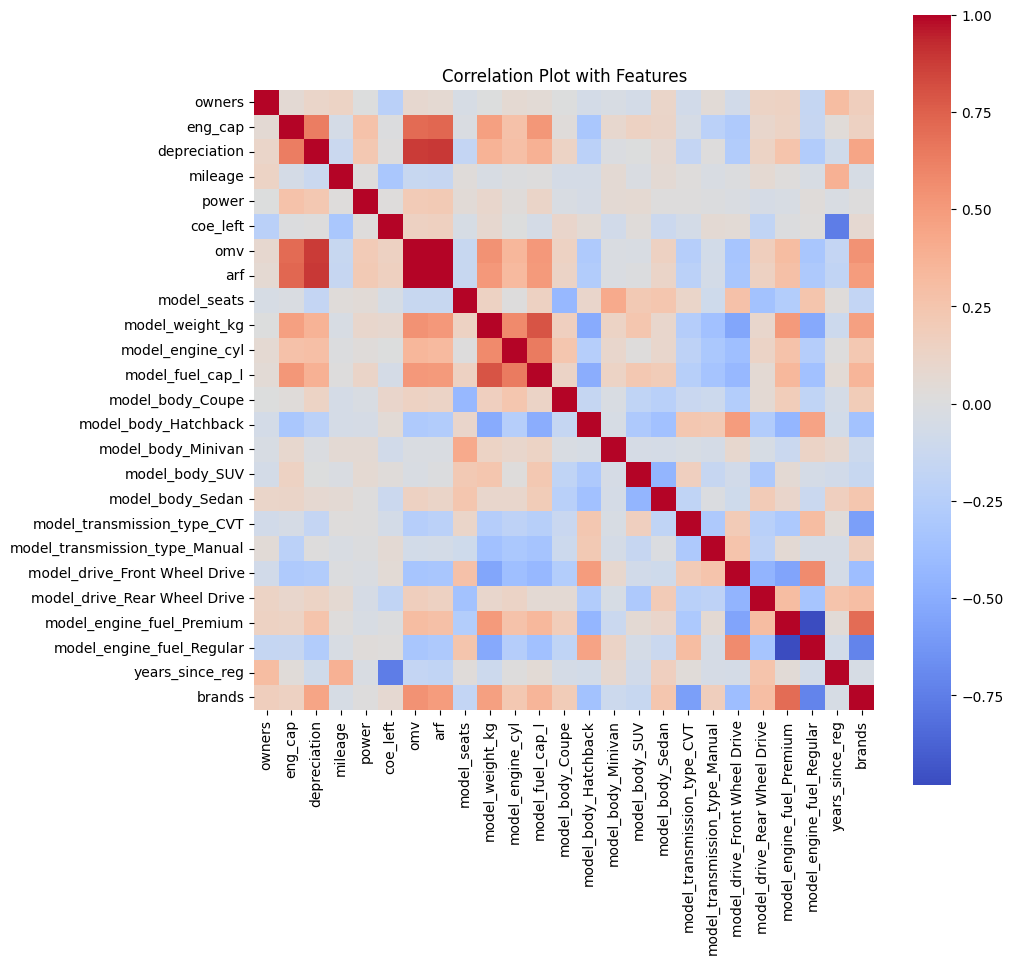

In [157]:
# plotting correlation heatmap between numeric variables

independent_vars = data.drop(columns=['price'])

correlation = independent_vars.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation, vmax=1, square=True, cmap="coolwarm")
plt.title("Correlation Plot with Features")

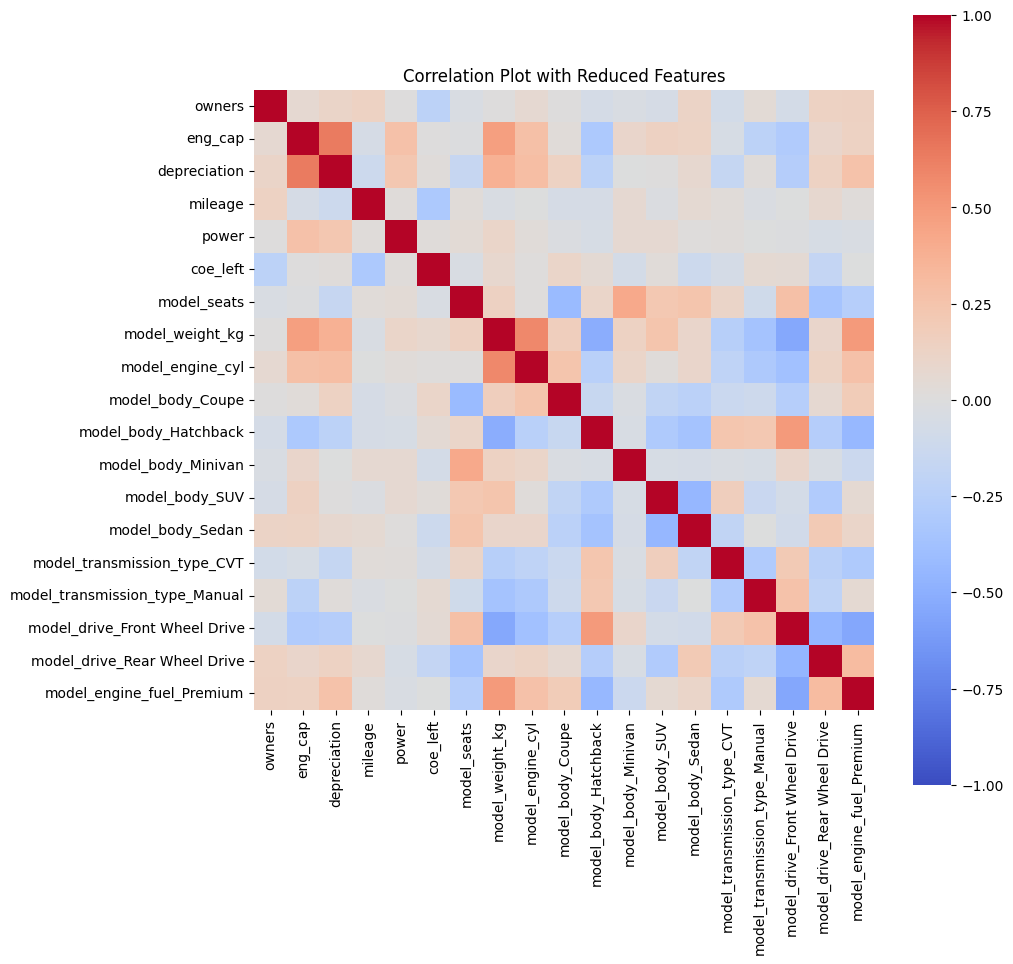

In [158]:
#identify pairs of highly correlated features
threshold = 0.7
upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

# find columns with correlation greater than the threshold
to_drop = [column for column in upper.columns if any(upper[column].abs() > threshold)]

# remove these columns from the DataFrame
independent_vars = independent_vars.drop(columns=to_drop)

# calculate the corr again
corr_reduced = independent_vars.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_reduced, vmax=1, vmin=-1, square=True, cmap="coolwarm")
plt.title('Correlation Plot with Reduced Features')
plt.show()

In [159]:
Y = np.log(data['price'])

# Linear Regression

In [160]:
# split the data up for testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_LR_train, X_LR_test, y_LR_train, y_LR_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.11378630019676161
MSE: 0.02680819431424861
RMSE: 0.1637320808951276
R^2: 0.9011085808160342
Adjusted R^2: 0.8973280235434077


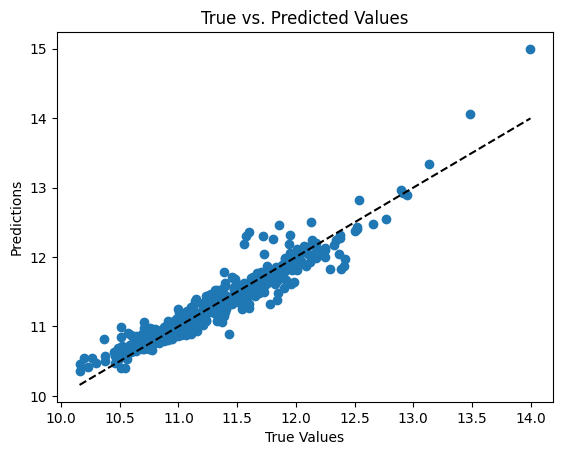

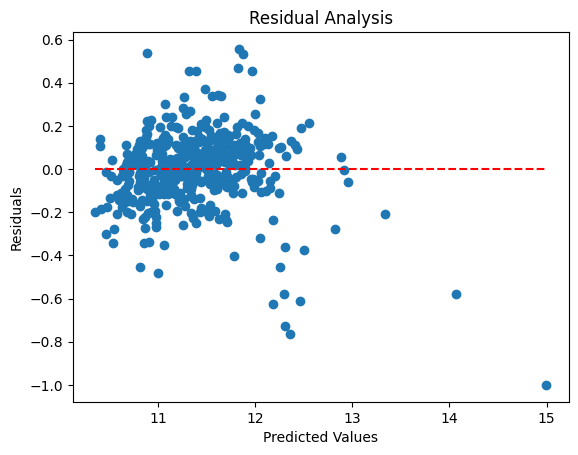

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,2487.0,100800.0,18300.0,78789.0,155.0,4.62,35969.0,32357.0,5,1469.841270,4,54.8825,False,False,False,False,True,False,False,True,False,False,True,6,1.0,104648.571016
1,2,1991.0,65800.0,25500.0,146000.0,135.0,0.43,47421.0,58390.0,5,1904.761905,4,79.8635,False,False,False,False,True,False,False,False,True,False,False,9,2.0,60547.734910
3,3,1984.0,72800.0,19890.0,108000.0,162.0,2.64,34596.0,40435.0,5,1479.818594,4,70.0225,False,False,False,False,True,False,False,True,False,False,True,8,2.0,67695.973166
4,1,1998.0,30800.0,19580.0,78524.0,177.0,0.04,17723.0,17723.0,5,1643.537415,4,60.1815,False,False,False,True,False,True,False,False,False,True,False,9,1.0,40347.753136
5,4,1598.0,33800.0,18170.0,133000.0,125.0,0.02,32618.0,27666.0,5,1514.739229,4,59.8030,False,False,False,False,True,False,False,False,True,True,False,9,2.0,36981.610925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,1,1591.0,63800.0,13600.0,110000.0,93.8,4.18,13775.0,13775.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,68849.281805
4197,1,1591.0,51800.0,13830.0,68388.0,93.8,3.28,12881.0,12881.0,5,1318.820862,4,49.9620,False,True,False,False,False,False,False,True,False,False,True,7,1.0,58789.792785
4198,1,1591.0,73800.0,14490.0,73679.0,93.8,4.58,14645.0,14645.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,76768.629222
4199,2,1591.0,63888.0,13250.0,108000.0,93.8,4.27,14456.0,14456.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,68609.577732


In [161]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()
linear_regressor.fit(X_LR_train, y_LR_train)
y_LR_pred = linear_regressor.predict(X_LR_test)

# Calculate R-squared
n_LR = X_LR_test.shape[0]  # number of observations
p_LR = X_LR_test.shape[1]  # number of features
mae_LR = mean_absolute_error(y_LR_test, y_LR_pred)
mse_LR = mean_squared_error(y_LR_test, y_LR_pred)
rmse_LR = mean_squared_error(y_LR_test, y_LR_pred, squared=False)
r2_LR = r2_score(y_LR_test, y_LR_pred)
adjusted_r2_LR = 1 - (1 - r2_LR) * ((n_LR - 1) / (n_LR - p_LR - 1))
print(f"MAE: {mae_LR}")
print(f"MSE: {mse_LR}")
print(f"RMSE: {rmse_LR}")
print(f"R^2: {r2_LR}")
print(f"Adjusted R^2: {adjusted_r2_LR}")

#plotting True VS Predicted
plt.scatter(y_LR_test, y_LR_pred)
plt.plot([y_LR_test.min(), y_LR_test.max()], [y_LR_test.min(), y_LR_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_LR = y_LR_test - y_LR_pred
plt.scatter(y_LR_pred, residuals_LR)
plt.hlines(y=0, xmin=y_LR_pred.min(), xmax=y_LR_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars 
predicted_price_LR = linear_regressor.predict(x)
linear_regressor_predicted = data.copy()
linear_regressor_predicted['predicted_price'] = np.exp(predicted_price_LR)
linear_regressor_predicted

# Best Lasso

In [162]:
# split the data up for testing

X_Lasso_train, X_Lasso_test, y_Lasso_train, y_Lasso_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

Best alpha: 0.001
MAE: 0.11548473159924814
MSE: 0.026957879194150387
RMSE: 0.16418854769486935
R^2: 0.9005564156821071
Adjusted R^2: 0.8967547494808195


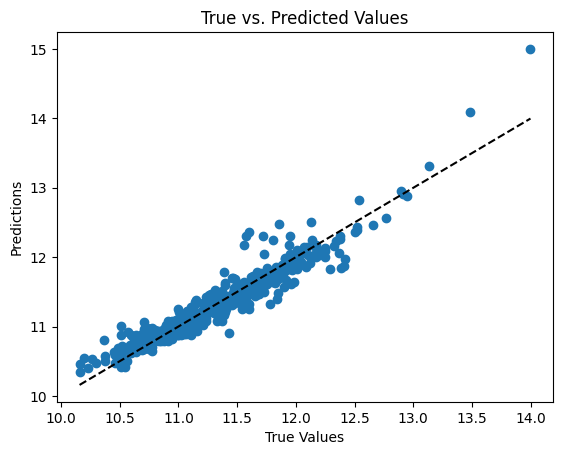

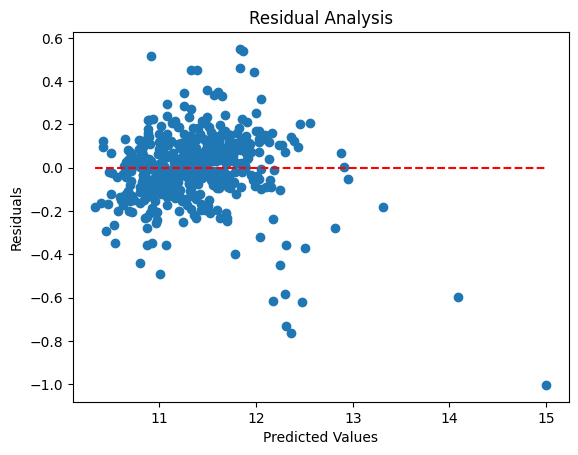

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,2487.0,100800.0,18300.0,78789.0,155.0,4.62,35969.0,32357.0,5,1469.841270,4,54.8825,False,False,False,False,True,False,False,True,False,False,True,6,1.0,103594.714862
1,2,1991.0,65800.0,25500.0,146000.0,135.0,0.43,47421.0,58390.0,5,1904.761905,4,79.8635,False,False,False,False,True,False,False,False,True,False,False,9,2.0,60566.252974
3,3,1984.0,72800.0,19890.0,108000.0,162.0,2.64,34596.0,40435.0,5,1479.818594,4,70.0225,False,False,False,False,True,False,False,True,False,False,True,8,2.0,67186.971280
4,1,1998.0,30800.0,19580.0,78524.0,177.0,0.04,17723.0,17723.0,5,1643.537415,4,60.1815,False,False,False,True,False,True,False,False,False,True,False,9,1.0,40514.106537
5,4,1598.0,33800.0,18170.0,133000.0,125.0,0.02,32618.0,27666.0,5,1514.739229,4,59.8030,False,False,False,False,True,False,False,False,True,True,False,9,2.0,36718.179515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,1,1591.0,63800.0,13600.0,110000.0,93.8,4.18,13775.0,13775.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,67427.684735
4197,1,1591.0,51800.0,13830.0,68388.0,93.8,3.28,12881.0,12881.0,5,1318.820862,4,49.9620,False,True,False,False,False,False,False,True,False,False,True,7,1.0,57626.751726
4198,1,1591.0,73800.0,14490.0,73679.0,93.8,4.58,14645.0,14645.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,75261.423546
4199,2,1591.0,63888.0,13250.0,108000.0,93.8,4.27,14456.0,14456.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,67330.438877


In [163]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV


lasso = Lasso()
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

#looping through to find best alpha value
grid_search = GridSearchCV(estimator=lasso, param_grid=parameters, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_Lasso_train, y_Lasso_train)

lasso = grid_search.best_estimator_
y_Lasso_pred = lasso.predict(X_Lasso_test)
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# Calculate R-squared
n_Lasso = X_Lasso_test.shape[0]  # number of observations
p_Lasso = X_Lasso_test.shape[1]  # number of features
mae_Lasso = mean_absolute_error(y_Lasso_test, y_Lasso_pred)
mse_Lasso = mean_squared_error(y_Lasso_test, y_Lasso_pred)
rmse_Lasso = mean_squared_error(y_Lasso_test, y_Lasso_pred, squared=False)
r2_Lasso = r2_score(y_Lasso_test, y_Lasso_pred)
adjusted_r2_Lasso = 1 - (1 - r2_Lasso) * ((n_Lasso - 1) / (n_Lasso - p_Lasso - 1))
print(f"MAE: {mae_Lasso}")
print(f"MSE: {mse_Lasso}")
print(f"RMSE: {rmse_Lasso}")
print(f"R^2: {r2_Lasso}")
print(f"Adjusted R^2: {adjusted_r2_Lasso}")

#plotting True VS Predicted
plt.scatter(y_Lasso_test, y_Lasso_pred)
plt.plot([y_Lasso_test.min(), y_Lasso_test.max()], [y_Lasso_test.min(), y_Lasso_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_Lasso = y_Lasso_test - y_Lasso_pred
plt.scatter(y_Lasso_pred, residuals_Lasso)
plt.hlines(y=0, xmin=y_Lasso_pred.min(), xmax=y_Lasso_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_Lasso = lasso.predict(x)
lasso_predicted_results = data.copy()
lasso_predicted_results['predicted_price'] = np.exp(predicted_price_Lasso)
lasso_predicted_results

# Decision Tree

In [164]:
# split the data up for testing

X_DT_train, X_DT_test, y_DT_train, y_DT_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.06452635976078554
MSE: 0.012048319792160025
RMSE: 0.10976483859670193
R^2: 0.9555555503268007
Adjusted R^2: 0.9538564667376844


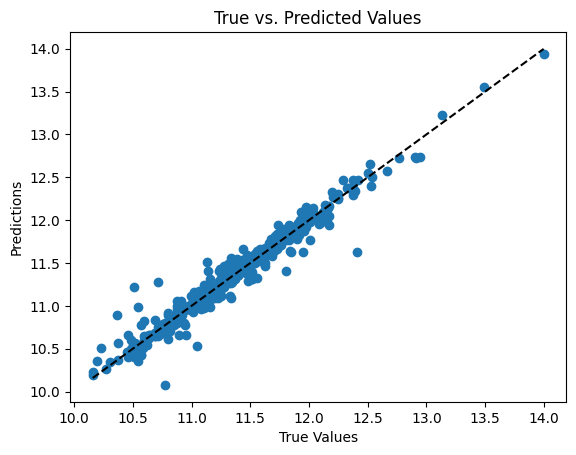

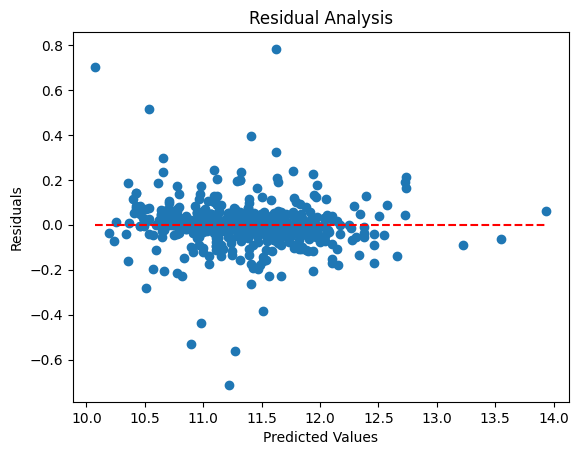

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,2487.0,100800.0,18300.0,78789.0,155.0,4.62,35969.0,32357.0,5,1469.841270,4,54.8825,False,False,False,False,True,False,False,True,False,False,True,6,1.0,100800.0
1,2,1991.0,65800.0,25500.0,146000.0,135.0,0.43,47421.0,58390.0,5,1904.761905,4,79.8635,False,False,False,False,True,False,False,False,True,False,False,9,2.0,65800.0
3,3,1984.0,72800.0,19890.0,108000.0,162.0,2.64,34596.0,40435.0,5,1479.818594,4,70.0225,False,False,False,False,True,False,False,True,False,False,True,8,2.0,72800.0
4,1,1998.0,30800.0,19580.0,78524.0,177.0,0.04,17723.0,17723.0,5,1643.537415,4,60.1815,False,False,False,True,False,True,False,False,False,True,False,9,1.0,30800.0
5,4,1598.0,33800.0,18170.0,133000.0,125.0,0.02,32618.0,27666.0,5,1514.739229,4,59.8030,False,False,False,False,True,False,False,False,True,True,False,9,2.0,33800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,1,1591.0,63800.0,13600.0,110000.0,93.8,4.18,13775.0,13775.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,67800.0
4197,1,1591.0,51800.0,13830.0,68388.0,93.8,3.28,12881.0,12881.0,5,1318.820862,4,49.9620,False,True,False,False,False,False,False,True,False,False,True,7,1.0,51800.0
4198,1,1591.0,73800.0,14490.0,73679.0,93.8,4.58,14645.0,14645.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,73800.0
4199,2,1591.0,63888.0,13250.0,108000.0,93.8,4.27,14456.0,14456.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,63888.0


In [165]:
from sklearn.tree import DecisionTreeRegressor


dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_DT_train, y_DT_train)
y_DT_pred = dt_regressor.predict(X_DT_test)

#Calculating R Squared
n_DT = X_DT_test.shape[0]  # number of observations
p_DT = X_DT_test.shape[1]  # number of features
mae_DT = mean_absolute_error(y_DT_test, y_DT_pred)
mse_DT = mean_squared_error(y_DT_test, y_DT_pred)
rmse_DT = mean_squared_error(y_DT_test, y_DT_pred, squared=False)
r2_DT = r2_score(y_DT_test, y_DT_pred)
adjusted_r2_DT = 1 - (1 - r2_DT) * ((n_DT - 1) / (n_DT - p_DT - 1))
print(f"MAE: {mae_DT}")
print(f"MSE: {mse_DT}")
print(f"RMSE: {rmse_DT}")
print(f"R^2: {r2_DT}")
print(f"Adjusted R^2: {adjusted_r2_DT}")

#plotting True VS Predicted
plt.scatter(y_DT_test, y_DT_pred)
plt.plot([y_DT_test.min(), y_DT_test.max()], [y_DT_test.min(), y_DT_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_DT = y_DT_test - y_DT_pred
plt.scatter(y_DT_pred, residuals_DT)
plt.hlines(y=0, xmin=y_DT_pred.min(), xmax=y_DT_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_DT = dt_regressor.predict(x)
dt_predicted = data.copy()
dt_predicted['predicted_price'] = np.exp(predicted_price_DT)
dt_predicted

# Random Forest

In [166]:
# split the data up for testing

X_RF_train, X_RF_test, y_RF_train, y_RF_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.04415857259182094
MSE: 0.005465599809330367
RMSE: 0.07392969504421323
R^2: 0.9798382197808445
Adjusted R^2: 0.9790674474988245


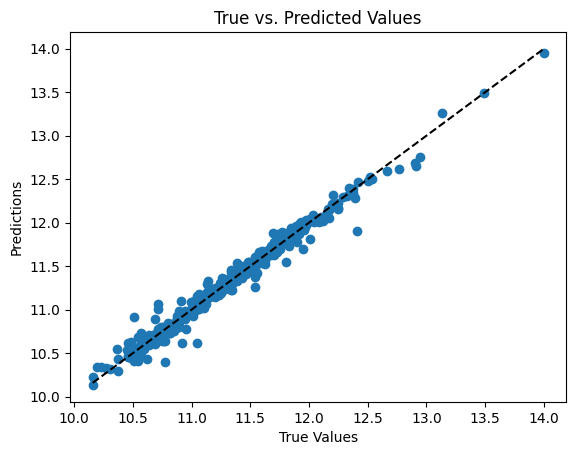

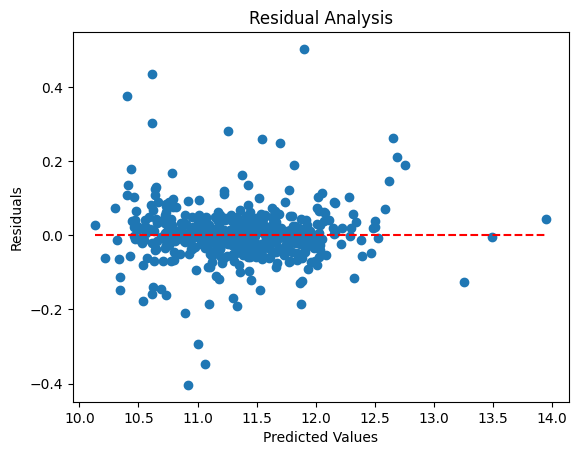

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,2487.0,100800.0,18300.0,78789.0,155.0,4.62,35969.0,32357.0,5,1469.841270,4,54.8825,False,False,False,False,True,False,False,True,False,False,True,6,1.0,101422.258231
1,2,1991.0,65800.0,25500.0,146000.0,135.0,0.43,47421.0,58390.0,5,1904.761905,4,79.8635,False,False,False,False,True,False,False,False,True,False,False,9,2.0,63679.971938
3,3,1984.0,72800.0,19890.0,108000.0,162.0,2.64,34596.0,40435.0,5,1479.818594,4,70.0225,False,False,False,False,True,False,False,True,False,False,True,8,2.0,71561.744990
4,1,1998.0,30800.0,19580.0,78524.0,177.0,0.04,17723.0,17723.0,5,1643.537415,4,60.1815,False,False,False,True,False,True,False,False,False,True,False,9,1.0,33472.717282
5,4,1598.0,33800.0,18170.0,133000.0,125.0,0.02,32618.0,27666.0,5,1514.739229,4,59.8030,False,False,False,False,True,False,False,False,True,True,False,9,2.0,33569.394314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,1,1591.0,63800.0,13600.0,110000.0,93.8,4.18,13775.0,13775.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,65490.780625
4197,1,1591.0,51800.0,13830.0,68388.0,93.8,3.28,12881.0,12881.0,5,1318.820862,4,49.9620,False,True,False,False,False,False,False,True,False,False,True,7,1.0,51604.969773
4198,1,1591.0,73800.0,14490.0,73679.0,93.8,4.58,14645.0,14645.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,73878.949665
4199,2,1591.0,63888.0,13250.0,108000.0,93.8,4.27,14456.0,14456.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,64142.127751


In [167]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # 100 trees
rf_regressor.fit(X_RF_train, y_RF_train)
y_RF_pred = rf_regressor.predict(X_RF_test)

# Calculating R-Squared
n_RF = X_RF_test.shape[0]  # number of observations
p_RF = X_RF_test.shape[1]  # number of features
mae_RF = mean_absolute_error(y_RF_test, y_RF_pred)
mse_RF = mean_squared_error(y_RF_test, y_RF_pred)
rmse_RF = mean_squared_error(y_RF_test, y_RF_pred, squared=False)
r2_RF = r2_score(y_RF_test, y_RF_pred)
adjusted_r2_RF = 1 - (1 - r2_RF) * ((n_RF - 1) / (n_RF - p_RF - 1))
print(f"MAE: {mae_RF}")
print(f"MSE: {mse_RF}")
print(f"RMSE: {rmse_RF}")
print(f"R^2: {r2_RF}")
print(f"Adjusted R^2: {adjusted_r2_RF}")

#plotting True VS Predicted
plt.scatter(y_RF_test, y_RF_pred)
plt.plot([y_RF_test.min(), y_RF_test.max()], [y_RF_test.min(), y_RF_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_RF = y_RF_test - y_RF_pred
plt.scatter(y_RF_pred, residuals_RF)
plt.hlines(y=0, xmin=y_RF_pred.min(), xmax=y_RF_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_RF = rf_regressor.predict(x)
rf_predicted = data.copy()
rf_predicted['predicted_price'] = np.exp(predicted_price_RF)
rf_predicted

# Gradient Boosting

In [168]:
# split the data up for testing

X_GB_train, X_GB_test, y_GB_train, y_GB_test = train_test_split(independent_vars, Y, test_size=0.2, random_state=42)

MAE: 0.052797371604040015
MSE: 0.006807851989673607
RMSE: 0.08250970845708769
R^2: 0.9748868522451964
Adjusted R^2: 0.9739267922706667


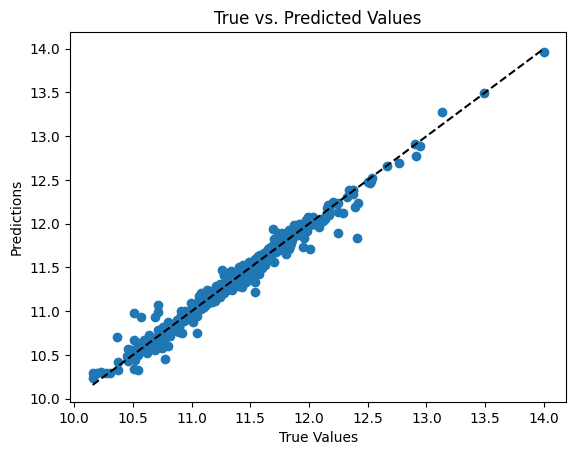

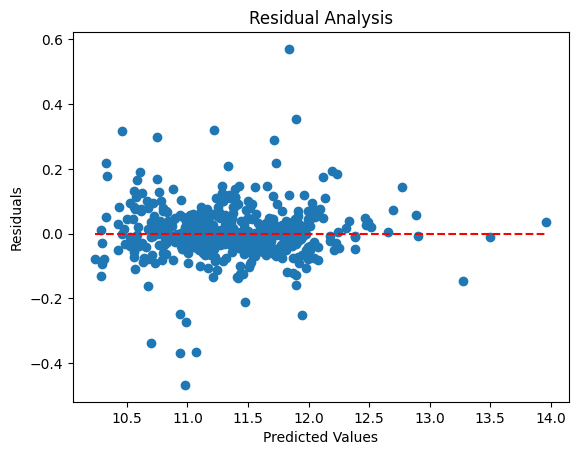

,owners,eng_cap,price,depreciation,mileage,power,coe_left,omv,arf,model_seats,model_weight_kg,model_engine_cyl,model_fuel_cap_l,model_body_Coupe,model_body_Hatchback,model_body_Minivan,model_body_SUV,model_body_Sedan,model_transmission_type_CVT,model_transmission_type_Manual,model_drive_Front Wheel Drive,model_drive_Rear Wheel Drive,model_engine_fuel_Premium,model_engine_fuel_Regular,years_since_reg,brands,predicted_price
0,1,2487.0,100800.0,18300.0,78789.0,155.0,4.62,35969.0,32357.0,5,1469.841270,4,54.8825,False,False,False,False,True,False,False,True,False,False,True,6,1.0,110806.530367
1,2,1991.0,65800.0,25500.0,146000.0,135.0,0.43,47421.0,58390.0,5,1904.761905,4,79.8635,False,False,False,False,True,False,False,False,True,False,False,9,2.0,69001.388203
3,3,1984.0,72800.0,19890.0,108000.0,162.0,2.64,34596.0,40435.0,5,1479.818594,4,70.0225,False,False,False,False,True,False,False,True,False,False,True,8,2.0,70336.192585
4,1,1998.0,30800.0,19580.0,78524.0,177.0,0.04,17723.0,17723.0,5,1643.537415,4,60.1815,False,False,False,True,False,True,False,False,False,True,False,9,1.0,34382.403660
5,4,1598.0,33800.0,18170.0,133000.0,125.0,0.02,32618.0,27666.0,5,1514.739229,4,59.8030,False,False,False,False,True,False,False,False,True,True,False,9,2.0,32145.573425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4196,1,1591.0,63800.0,13600.0,110000.0,93.8,4.18,13775.0,13775.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,66130.363295
4197,1,1591.0,51800.0,13830.0,68388.0,93.8,3.28,12881.0,12881.0,5,1318.820862,4,49.9620,False,True,False,False,False,False,False,True,False,False,True,7,1.0,52030.197838
4198,1,1591.0,73800.0,14490.0,73679.0,93.8,4.58,14645.0,14645.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,72747.383791
4199,2,1591.0,63888.0,13250.0,108000.0,93.8,4.27,14456.0,14456.0,5,1334.693878,4,52.9900,False,True,False,False,False,False,False,True,False,False,True,6,1.0,65076.505404


In [169]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)  # 100 trees
gb_regressor.fit(X_GB_train, y_GB_train)
y_GB_pred = gb_regressor.predict(X_GB_test)

# Calculating R-Squared
n_GB = X_GB_test.shape[0]  # number of observations
p_GB = X_GB_test.shape[1]  # number of features
mae_GB = mean_absolute_error(y_GB_test, y_GB_pred)
mse_GB = mean_squared_error(y_GB_test, y_GB_pred)
rmse_GB = mean_squared_error(y_GB_test, y_GB_pred, squared=False)
r2_GB = r2_score(y_GB_test, y_GB_pred)
adjusted_r2_GB = 1 - (1 - r2_GB) * ((n_GB - 1) / (n_GB - p_GB - 1))
print(f"MAE: {mae_GB}")
print(f"MSE: {mse_GB}")
print(f"RMSE: {rmse_GB}")
print(f"R^2: {r2_GB}")
print(f"Adjusted R^2: {adjusted_r2_GB}")

#plotting True VS Predicted
plt.scatter(y_GB_test, y_GB_pred)
plt.plot([y_GB_test.min(), y_GB_test.max()], [y_GB_test.min(), y_GB_test.max()], '--k')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')
plt.show()

# Residual plot
residuals_GB = y_GB_test - y_GB_pred
plt.scatter(y_GB_pred, residuals_GB)
plt.hlines(y=0, xmin=y_GB_pred.min(), xmax=y_GB_pred.max(), colors='red', linestyles='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()

# test back on the dataset
x = independent_vars
predicted_price_GB = gb_regressor.predict(x)
gb_predicted = data.copy()
gb_predicted['predicted_price'] = np.exp(predicted_price_GB)
gb_predicted

In [170]:
from sklearn.model_selection import cross_val_score

gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)

# For regression, it's common to use negative mean squared error as the scoring method
scores = cross_val_score(gb_regressor, independent_vars, Y, cv=10, scoring='neg_mean_squared_error')

mean_mse = -scores.mean()  # Negate to get positive MSE
rmse = mean_mse ** 0.5  # Calculate RMSE from MSE

print(f"Mean MSE from 10-fold CV: {mean_mse}")
print(f"Mean RMSE from 10-fold CV: {rmse}")


Mean MSE from 10-fold CV: 0.012095937171375113
Mean RMSE from 10-fold CV: 0.10998153104669489


The cross-validation results show a Mean MSE of approximately 0.0017 and a Mean RMSE of approximately 0.0415. These values are quite close to the ones previously reported from a single train-test split (MSE: 0.001674, RMSE: 0.0409), which suggests the model is performing consistently across different subsets of the data and is not likely to be overfitted